In [7]:
import pandas as pd

df = pd.read_csv("data/raw_data/calories.csv")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


In [9]:
df.drop(columns=["User_ID"], inplace=True)

In [10]:
def check_if_there_is_empty_cell(dataframe):
    rows_with_empty_cell = dataframe.isnull().any(axis=1).sum()
    dataframe.dropna(inplace=True)
    print(f"Deleted empty cells: {rows_with_empty_cell}")

check_if_there_is_empty_cell(df)

Deleted empty cells: 0


In [11]:
def check_if_there_are_the_same_cell(dataframe, target_column):

    full_duplicates_count = dataframe.duplicated().sum()
    dataframe.drop_duplicates(inplace=True)
    print(f"Deleted {full_duplicates_count} exact duplicate rows (including '{target_column}').")

    feature_cols = [col for col in dataframe.columns if col != target_column]

    partial_duplicate_mask = dataframe.duplicated(subset=feature_cols, keep=False)
    partial_duplicates_count = partial_duplicate_mask.sum()
    dataframe.drop(index=dataframe[partial_duplicate_mask].index, inplace=True)
    print(f"Deleted {partial_duplicates_count} partial duplicates (same features, different '{target_column}').")

check_if_there_are_the_same_cell(df, target_column='Calories')

Deleted 1 exact duplicate rows (including 'Calories').
Deleted 0 partial duplicates (same features, different 'Calories').


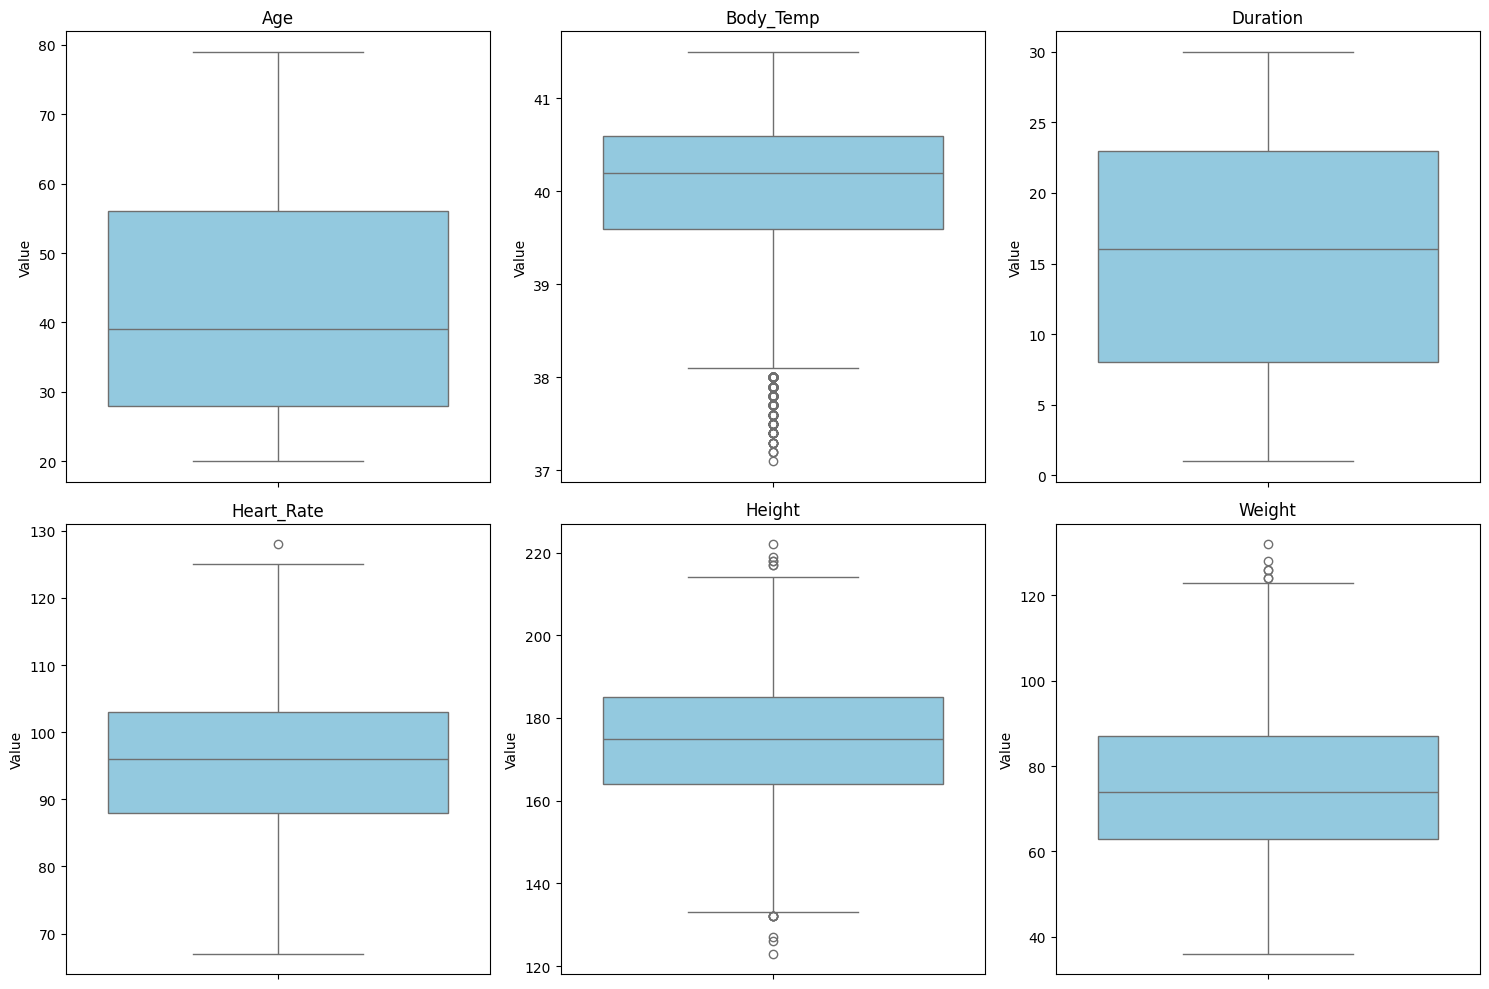

In [16]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

numerical_columns = df.select_dtypes(include=[np.number]).columns
numerical_columns = numerical_columns.difference(['Calories'])
n = len(numerical_columns)

ncols = 3
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.boxplot(y=df[col], ax=axes[i], color='skyblue')
    axes[i].set_title(col)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Value')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


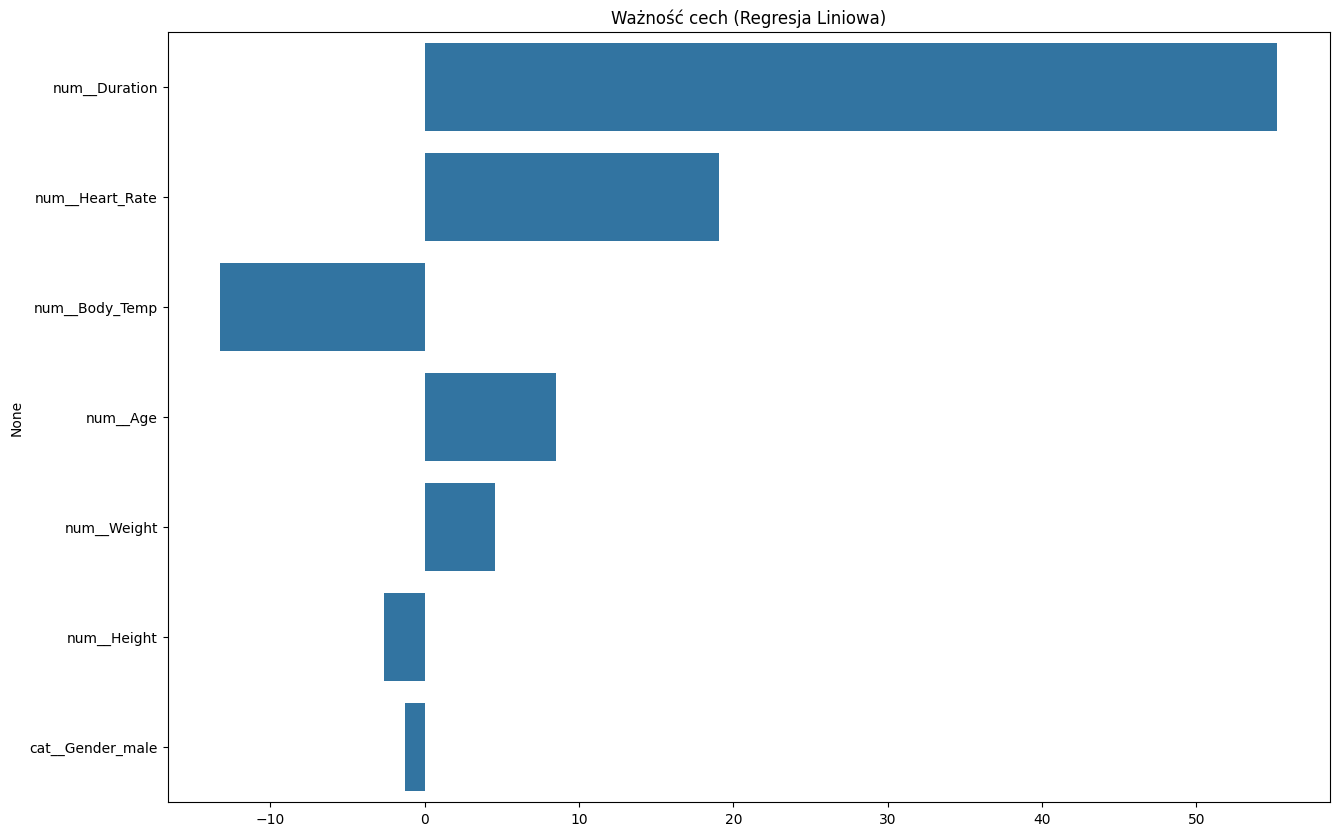

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

X = df.drop('Calories', axis=1)
y = df['Calories']

numerical_columns = X.select_dtypes(include=[np.number]).columns
categorical_columns = X.select_dtypes(include=['object', 'category']).columns

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_columns),
    ('cat', OneHotEncoder(drop='first'), categorical_columns)
])

model  = Pipeline([
    ('prep', preprocessor),
    ('reg', LinearRegression())
])

model .fit(X, y)

feature_names = model .named_steps['prep'].get_feature_names_out()
coefs = model.named_steps['reg'].coef_

importance = pd.Series(coefs, index=feature_names).sort_values(key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importance.values, y=importance.index)
plt.title("Feature importance (Linear Regression)")
plt.show()

In [27]:
df.drop(columns=['Gender', 'Height', 'Weight', 'Age'], inplace=True)

In [28]:
df.to_csv("data/preprocessed_data/preprocessed_calories.csv", index=False)